In [12]:
import os
import scipy
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import sklearn.cluster
import sklearn.mixture
import seaborn as sns
import matplotlib.pyplot as plt

In [13]:
print(pd.__version__)

1.3.5


In [14]:
basepath = './../../data/'
systems = [os.path.join(basepath, system) for system in os.listdir(basepath)]

measurements_file = 'measurements.csv'

In [15]:
def plot_corr(df):
    sns.scatterplot(data=df, x='performance', y='energy')
    plt.show()

    
def window_sections(df, window_pct=0.05, stepsize=0.5, mode='data', n_windows=30):
    # mode: [data|window]
    correlation_frames = []
    if mode=='window':
        min_perf = min(df.performance)
        max_perf = max(df.performance)
        value_range = max_perf-min_perf

        window_width = value_range*window_pct
        current_perf = min_perf

        while current_perf < max_perf - (window_width*stepsize) - 1 :
            window_df = df[(df['performance'] >= current_perf) & (df['performance'] <= current_perf+window_width)]

            if len(window_df) > 2:
                corr, p_value = scipy.stats.pearsonr(window_df['performance'].to_numpy(),
                                                 window_df['energy'].to_numpy())
                correlation_frames.append([corr])

            current_perf = current_perf+window_width*stepsize
    elif mode == 'data':
        df.sort_values(by=['performance'])
        current_window = 0.0
        total_len = len(df)
        stepsize = total_len / n_windows
        while current_window < n_windows:
            current_window
            window_df = df.iloc[round(stepsize*current_window) : round(stepsize*current_window + stepsize)]
            corr, p_value = scipy.stats.pearsonr(window_df['performance'].to_numpy(),
                                                 window_df['energy'].to_numpy())
            correlation_frames.append([corr])
            
            current_window += 1
    
    return correlation_frames


def corr_cluster(df, identifier='cluster'):
    correlation_cluster = []
    
    for key, tmp in df.groupby([identifier]):
        if len(tmp) < 2:
            continue
        
        corr, p_value = scipy.stats.pearsonr(tmp['performance'],tmp['energy'])
        correlation_cluster.append([corr])
    return correlation_cluster


def calc_lin_err(x, y, slope, intercept):
    return abs(y-(intercept+(slope*x)))


def cluster_dbscan(df, stepsize=0.01):
    x = df['performance'].to_numpy()
    eps = stepsize * (x.max() - x.min())
    cluster = sklearn.cluster.DBSCAN(eps=eps, min_samples=len(df)/200).fit(x.reshape(-1, 1))
    df['DBSCAN'] = cluster.labels_
    print('number clusters DBSCAN', len(df.DBSCAN.unique()))
    return df


def cluster_gmm(df):
    x = df['performance'].to_numpy()
    y = df['energy'].to_numpy()
    #data = np.stack([x,y]).T
    data = x.reshape(-1, 1)
    model = sklearn.mixture.BayesianGaussianMixture(n_components=20, max_iter=1000, init_params='random').fit(data)
    y_pred = model.predict(data)
    df['GMM'] = y_pred
    print('number clusters GMM', len(df.GMM.unique()))
    return df
    
def window_correlation(df):
    corr_bb, p_value = scipy.stats.pearsonr(df['performance'].to_numpy(),
                                             df['energy'].to_numpy())
    
    fig2, axes2 = plt.subplots(ncols=2, nrows=1, constrained_layout=True, figsize=(12,3))
    
    correlation_frames = window_sections(df, mode='window')
    sns.histplot(pd.DataFrame(data=correlation_frames, columns=['Pearson']), bins=20, kde=False, ax=axes2[0])
    axes2[0].axvline(corr_bb, ls='--', color='r')
    axes2[0].set_xlabel('Correlation of Window')
    axes2[0].set_title('Window Correlation')
    
    correlation_frames = window_sections(df, mode='data')
    sns.histplot(pd.DataFrame(data=correlation_frames, columns=['Pearson']), bins=20, kde=False, ax=axes2[1])
    axes2[1].axvline(corr_bb, ls='--', color='r')
    axes2[1].set_xlabel('Correlation of Dataslice')
    axes2[1].set_title('Dataslice Correlation')
    
    plt.show()
    
def correlation_error(df):
    min_perf = min(df.performance)
    max_perf = max(df.performance)
    
    print('Min perf:', min_perf, ' - Max perf:', max_perf)
    
    x = df['performance'].to_numpy()
    y = df['energy'].to_numpy()
    
    corr_bb, p_value = scipy.stats.pearsonr(x, y)
    print('Datapoints', len(df))
    print('Overall Correlation:', corr_bb)
    print()
    
    slope, intercept, r, p, stderr = scipy.stats.linregress(x, y)
    
    fig1, axes = plt.subplots(ncols=3, nrows=1, constrained_layout=True, figsize=(12,3))
    
    sns.scatterplot(data=df, x='performance', y='energy', ax=axes[0], marker='+')
    axes[0].plot(x, intercept + slope * x, label="Regression Line")
    axes[0].set_title('Linear Regression')
    
    df['Lin Err'] = df.apply(lambda row: calc_lin_err(row['performance'], row['energy'], slope, intercept), axis=1)
    sns.histplot(pd.DataFrame(data=df, columns=['Lin Err']), bins=20, kde=False, ax=axes[1])
    axes[1].set_xlabel('Error Abs')
    axes[1].set_title('Linear Regression Absolute Error')
    
    df['Lin Err Norm'] = df['Lin Err']/df['energy']*100
    sns.histplot(pd.DataFrame(data=df, columns=['Lin Err Norm']), bins=20, kde=False, ax=axes[2])
    axes[2].set_xlabel('Error in %')
    axes[2].set_title('Linear Regression Relative Error')
    print('Largest Error', max(list(df['Lin Err'])))
    print('Largest Relative Error', max(list(df['Lin Err Norm'])), 'Mean Energy', df['energy'].mean())
    print('Mean Relative Error', df['Lin Err Norm'].mean())
    
    plt.show()
    return df

def correlation_error_joint(df):
    x = df['performance'].to_numpy()
    y = df['energy'].to_numpy()
    slope, intercept, r, p, stderr = scipy.stats.linregress(x, y)
    g1 = sns.jointplot(data=df, x='performance', y='energy', marker='+', height=4)
    g1.ax_joint.plot(x, intercept + slope * x, label="Regression Line")
    
    g2 = sns.jointplot(data=df, x='performance', y='energy', marker='+', height=4)
    g2.ax_joint.plot(x, intercept + slope * x, label="Regression Line")
    g2.ax_joint.set_xscale('log')
    g2.ax_joint.set_yscale('log')
    
    plt.show()
    return

def clustering(df):
    min_perf = min(df.performance)
    max_perf = max(df.performance)
    corr_bb, p_value = scipy.stats.pearsonr(df['performance'].to_numpy(),
                                             df['energy'].to_numpy())
    
    fig2, axes2 = plt.subplots(ncols=4, nrows=1, constrained_layout=True, figsize=(12,5))
    
    df = cluster_dbscan(df)
    sns.scatterplot(data=df, x='performance', y='energy', hue='DBSCAN', ax=axes2[0])
    axes2[0].set_xlabel('Performance [s]')
    axes2[0].set_ylabel('Energy Consumption [J]')
    axes2[0].set_title('DBSCAN')
    
    correlation_cluster = corr_cluster(df, 'DBSCAN')
    sns.histplot(pd.DataFrame(data=correlation_cluster, columns=['cluster']), bins=20, kde=False, ax=axes2[1])
    axes2[1].axvline(corr_bb, ls='--', color='r')
    axes2[1].set_title('DBSCAN Correlation')
    
    
    df = cluster_gmm(df)
    sns.scatterplot(data=df, x='performance', y='energy', hue='GMM', ax=axes2[2])
    axes2[2].set_xlabel('Performance [s]')
    axes2[2].set_ylabel('Energy Consumption [J]')
    axes2[2].set_title('GMM')
    
    correlation_cluster = corr_cluster(df, 'GMM')
    sns.histplot(pd.DataFrame(data=correlation_cluster, columns=['cluster']), bins=20, kde=False, ax=axes2[3])
    axes2[3].axvline(corr_bb, ls='--', color='r')
    axes2[3].set_title('GMM Correlation')

    plt.show()

def correlation_results(df, system):
    results = []
    min_perf = min(df.performance)
    max_perf = max(df.performance)
    
    # Linear Correlation
    corr_bb, p_value = scipy.stats.pearsonr(df['performance'].to_numpy(),
                                             df['energy'].to_numpy())
    
    #Linear Regression
    x = df['performance'].to_numpy()
    y = df['energy'].to_numpy()
    slope, intercept, r, p, stderr = scipy.stats.linregress(x, y)
    
    df['Lin Err'] = df.apply(lambda row: calc_lin_err(row['performance'], row['energy'], slope, intercept), axis=1)
    df['Lin Err ape'] = df['Lin Err']/df['energy']*100
    mape = df['Lin Err ape'].mean()
    std = df['Lin Err ape'].std()
    
    # Correlation Windows
    # Thresolds: (-1) : (-0.7) : (-0.3) : 0.3 : 0.7 : 1
    # Strong N : Moderate N : Weak/None : Moderate P : Strong P
    bins = [-1, -0.7, -0.3, 0.3, 0.7, 1]
    
    correlation_frames = window_sections(df, window_pct=0.1, stepsize=0.5, mode='window')
    tmp_df = pd.DataFrame(data=correlation_frames, columns=['c'])
    
    #print(list(tmp_df['c'].value_counts(bins=bins, sort=False)))
    
    results.append([system, corr_bb, mape, std]+list(tmp_df['c'].value_counts(bins=bins, sort=False)))
    return pd.DataFrame(results, columns=['System', 'Pearson', 'MAPE', 'StD', 'SN', 'MN', 'WN', 'MP', 'SP'])



~+~+~+~+~+~+~+~+~+~+~+~+~+~+~+~+
brotli
Min perf: 0.558  - Max perf: 314.332
Datapoints 180
Overall Correlation: 0.9999541761468111

Largest Error 124.30992632410016
Largest Relative Error 73.09985929506388 Mean Energy 1578.2766666666669
Mean Relative Error 9.362309649338012


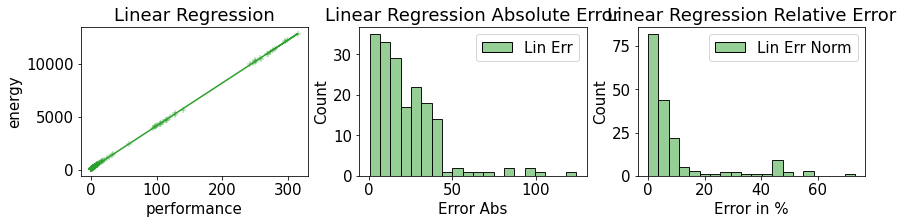

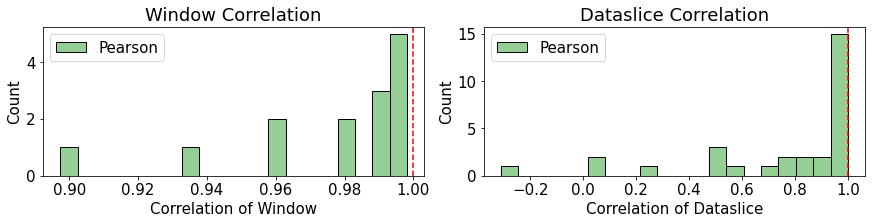



~+~+~+~+~+~+~+~+~+~+~+~+~+~+~+~+
jump3r
Workload dual-channel.wav
Min perf: 0.596  - Max perf: 1957.264
Datapoints 4296
Overall Correlation: 0.9966947447237549

Largest Error 10286.801188025827
Largest Relative Error 75.12522766259207 Mean Energy 736.5875497310163
Mean Relative Error 10.07376088427494


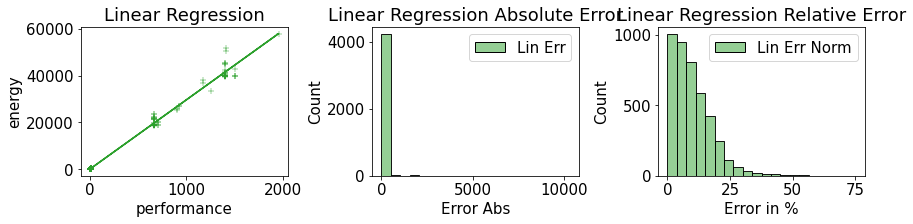

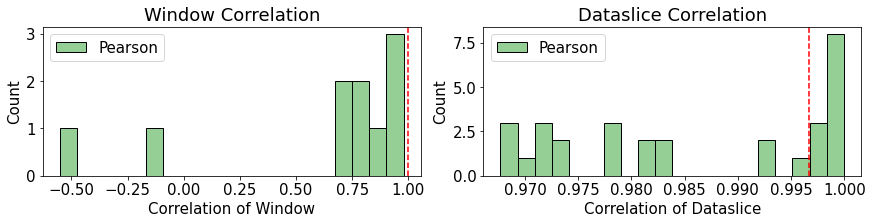



~+~+~+~+~+~+~+~+~+~+~+~+~+~+~+~+
MongoDB
Min perf: 206356.0  - Max perf: 341753.2
Datapoints 6840
Overall Correlation: 0.992014460520368

Largest Error 739.6512137661648
Largest Relative Error 7.6421302023656805 Mean Energy 10230.40128654971
Mean Relative Error 1.6989472174721387


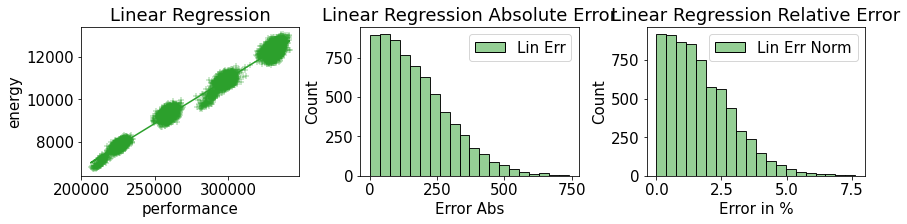

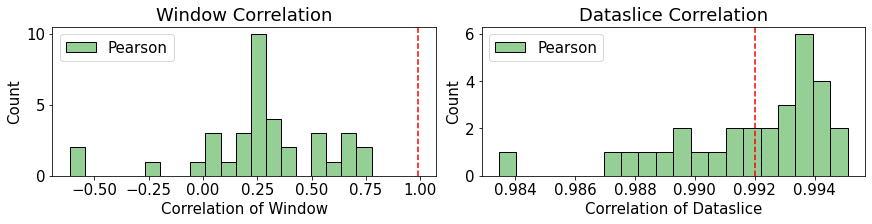



~+~+~+~+~+~+~+~+~+~+~+~+~+~+~+~+
LLVM
Min perf: 52285.4  - Max perf: 103691.8
Datapoints 65536
Overall Correlation: 0.9964093395607221

Largest Error 214.45270662131043
Largest Relative Error 8.655663005380628 Mean Energy 2654.2983642578124
Mean Relative Error 0.7970528135693291


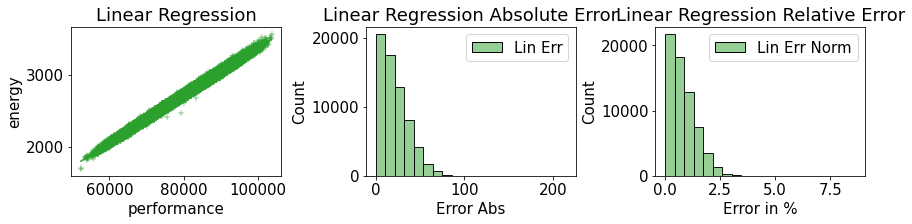

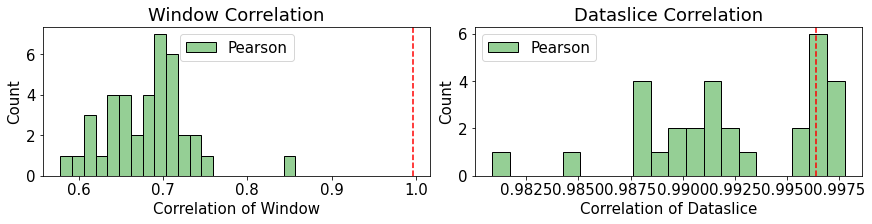



~+~+~+~+~+~+~+~+~+~+~+~+~+~+~+~+
x264
Min perf: 21.556  - Max perf: 195.776
Datapoints 4608
Overall Correlation: 0.9625929679114029

Largest Error 0.8752802416084755
Largest Relative Error 28.432359249164186 Mean Energy 2.6798486979166665
Mean Relative Error 10.360177309928984


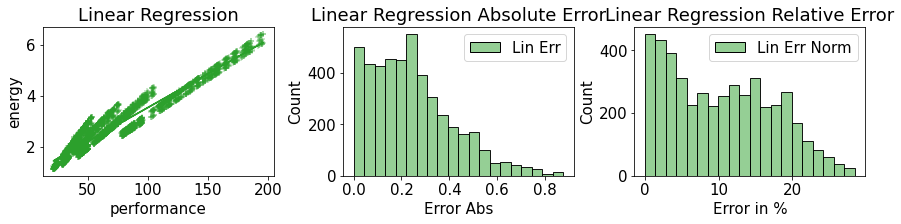

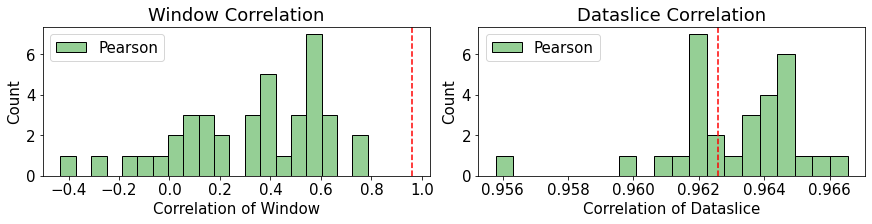



~+~+~+~+~+~+~+~+~+~+~+~+~+~+~+~+
kanzi
Workload v5.12.tar
Min perf: 3.558  - Max perf: 4940.288
Datapoints 3202
Overall Correlation: 0.9766604049119045

Largest Error 70850.38266154286
Largest Relative Error 462.7213717493138 Mean Energy 19559.58496653922
Mean Relative Error 70.43173695926725


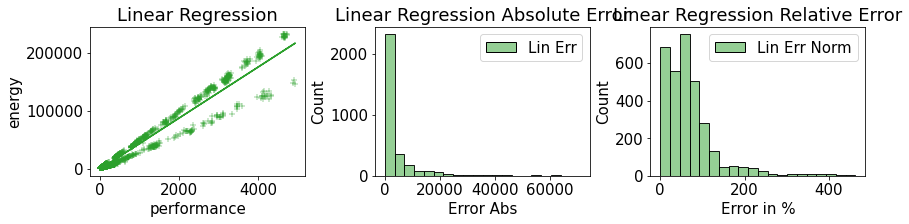

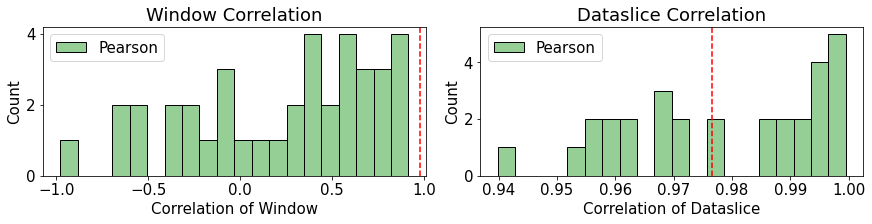



~+~+~+~+~+~+~+~+~+~+~+~+~+~+~+~+
PostgreSQL
Min perf: 46516.0  - Max perf: 56725.8
Datapoints 864
Overall Correlation: 0.9588893325730249

Largest Error 94.4653557480608
Largest Relative Error 5.709946551502708 Mean Energy 1628.2465277777778
Mean Relative Error 1.2976722566347876


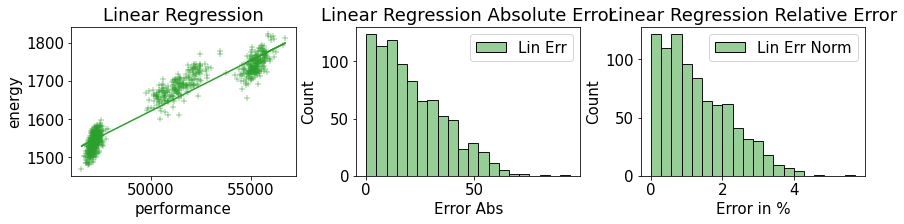

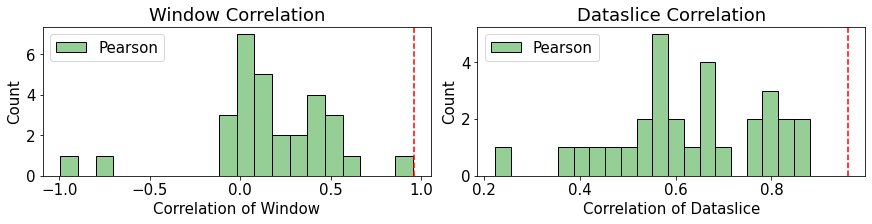



~+~+~+~+~+~+~+~+~+~+~+~+~+~+~+~+
nginx
Min perf: 2.0566  - Max perf: 427.1286
Datapoints 4416
Overall Correlation: 0.9994651210235547

Largest Error 853.4180063977328
Largest Relative Error 143.9180902870417 Mean Energy 9198.960733695652
Mean Relative Error 8.285394035654088


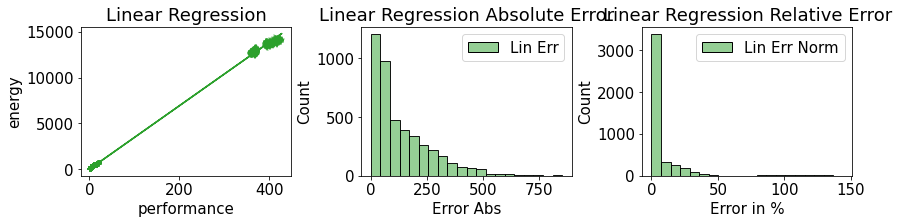

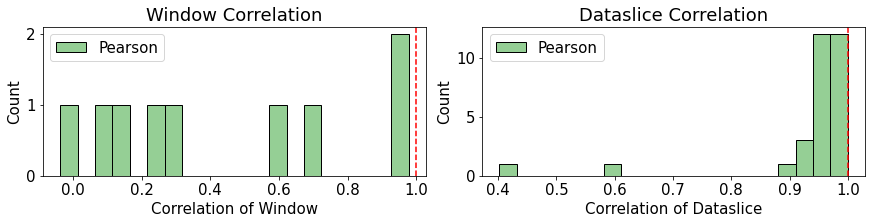



~+~+~+~+~+~+~+~+~+~+~+~+~+~+~+~+
exastencils
Min perf: 4642.4  - Max perf: 19707.8
Datapoints 86058
Overall Correlation: 0.9867283836552907

Largest Error 101.55827874819397
Largest Relative Error 66.32733698110523 Mean Energy 315.65630156406155
Mean Relative Error 5.730121735854243


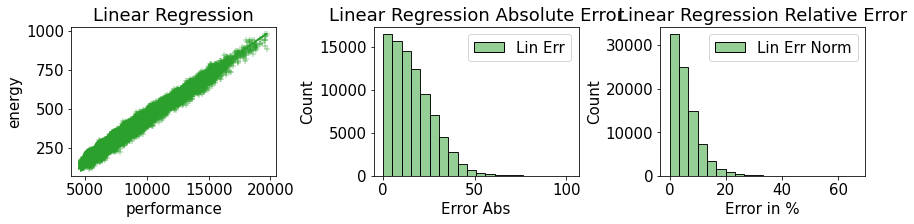

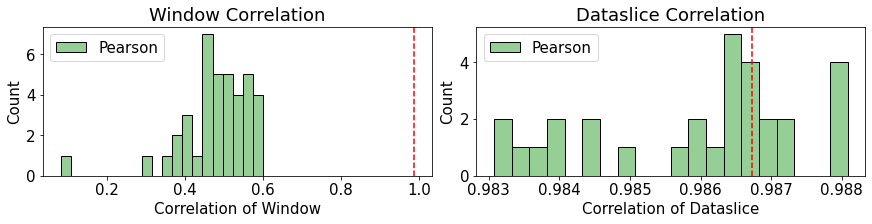



~+~+~+~+~+~+~+~+~+~+~+~+~+~+~+~+
7z
Min perf: 4196.4  - Max perf: 424574.6
Datapoints 68640
Overall Correlation: 0.9884815801165082

Largest Error 3250.459597567333
Largest Relative Error 73.09268421213577 Mean Energy 2037.1578088578085
Mean Relative Error 14.793548148470265


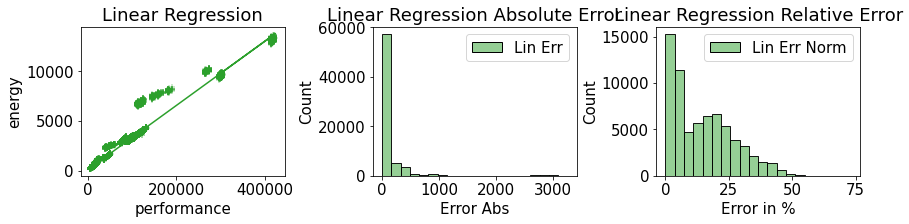

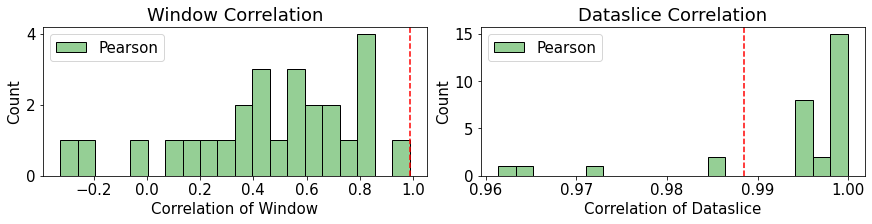



~+~+~+~+~+~+~+~+~+~+~+~+~+~+~+~+
VP8
Min perf: 5183.8  - Max perf: 61545.0
Datapoints 2736
Overall Correlation: 0.96545864071819

Largest Error 397.1653612600925
Largest Relative Error 74.30201524236107 Mean Energy 1001.939985380117
Mean Relative Error 22.056542234809573


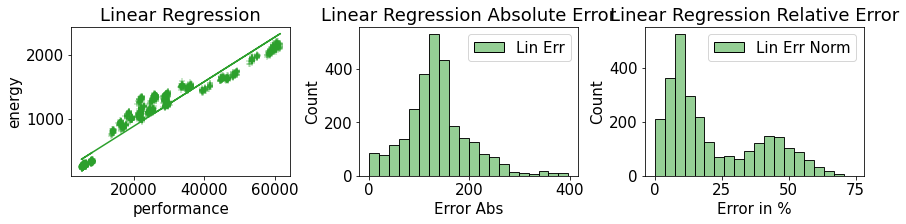

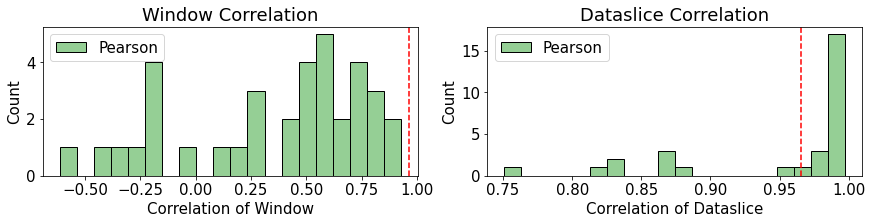



~+~+~+~+~+~+~+~+~+~+~+~+~+~+~+~+
Apache
Min perf: 31.2776  - Max perf: 169.1536
Datapoints 640
Overall Correlation: 0.9986104658029944

Largest Error 353.149391245257
Largest Relative Error 9.275298715881224 Mean Energy 6171.0603125
Mean Relative Error 2.224026608874759


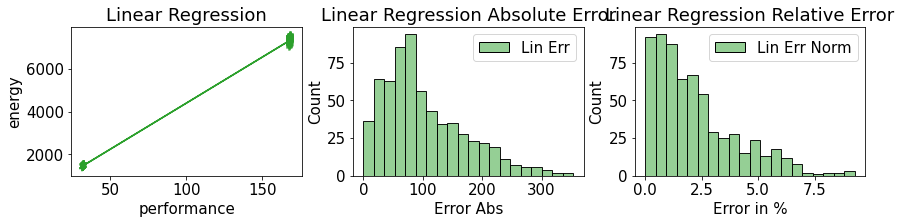

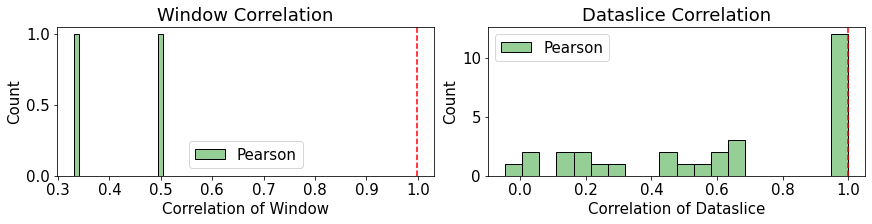



~+~+~+~+~+~+~+~+~+~+~+~+~+~+~+~+
lrzip
Min perf: 9645.6  - Max perf: 1659485.4
Datapoints 5184
Overall Correlation: 0.9896883570424823

Largest Error 14319.695628680649
Largest Relative Error 115.84010666611879 Mean Energy 5022.8871141975305
Mean Relative Error 31.095766481514023


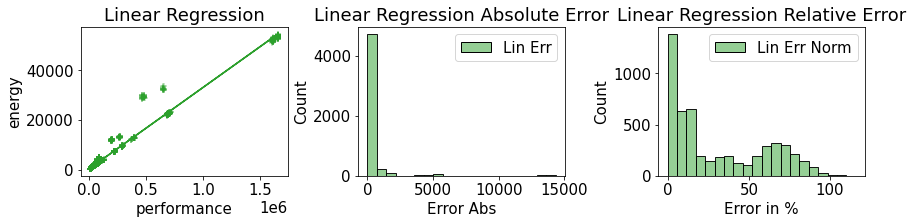

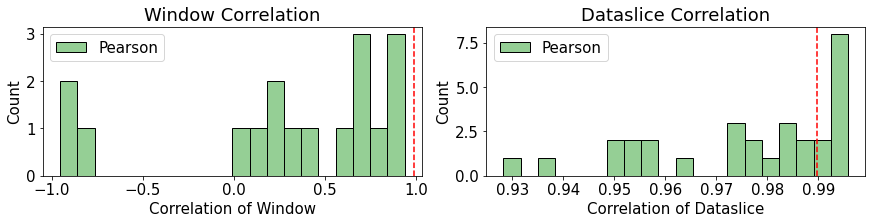



~+~+~+~+~+~+~+~+~+~+~+~+~+~+~+~+
HSQLDB
Min perf: 248.2  - Max perf: 520.2
Datapoints 864
Overall Correlation: 0.9932147415583714

Largest Error 1.3502283454796533
Largest Relative Error 10.920159230542577 Mean Energy 9.29477638888889
Mean Relative Error 3.0880223980905885


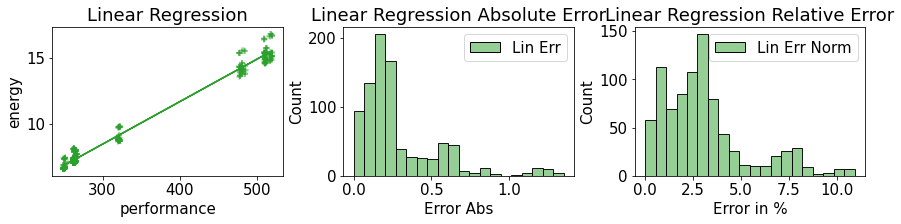

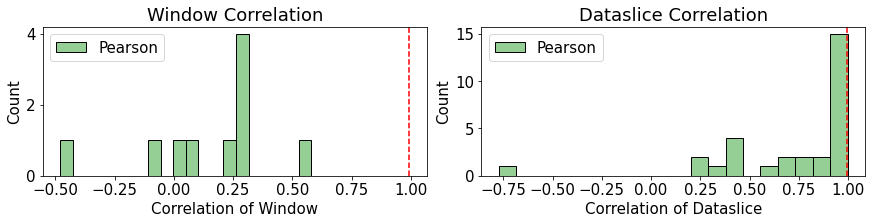

,root,compressed_script,encryption,crypt_aes,crypt_blowfish,transaction_control,txc_mvlocks,txc_mvcc,txc_locks,table_type,...,large_cache,logging,detailed_logging,no_write_delay,small_log,energy,performance,Lin Err,Lin Err Norm,Lin Err ape
0,1,0,0,0,0,1,0,0,1,1,...,0,0,0,0,0,6.6386,248.6,0.211974,3.193049,3.193049
1,1,0,1,1,0,1,0,0,1,1,...,0,0,0,0,0,6.6458,249.8,0.243050,3.657200,3.657200
2,1,0,1,1,0,1,0,0,1,1,...,0,1,0,0,0,6.6662,250.6,0.248168,3.722779,3.722779
3,1,0,1,1,0,1,0,0,1,1,...,0,1,0,1,0,6.7028,250.0,0.192430,2.870884,2.870884
4,1,0,1,1,0,1,0,0,1,1,...,0,1,0,1,1,6.6742,251.4,0.265686,3.980785,3.980785
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
859,1,0,0,0,0,1,1,0,0,1,...,0,0,0,0,1,7.9944,264.4,0.639852,8.003757,8.003757
860,1,0,0,0,0,1,0,0,1,1,...,0,0,0,1,0,7.1068,262.2,0.177574,2.498650,2.498650
861,1,0,0,0,0,1,0,0,1,1,...,0,0,0,1,1,7.1470,264.8,0.220306,3.082503,3.082503
862,1,0,0,0,0,1,0,0,1,1,...,0,0,0,0,1,7.9676,264.6,0.606673,7.614249,7.614249


In [16]:
df_dump_paper_plots = []
paper_systems = ['brotli', 'jump3r', 'x264', '7z']
corr_dfs = []

for system in systems:
    df = pd.read_csv(os.path.join(system, measurements_file), delimiter=';')
    system_name = system.rsplit('/', 1)[1]
    print()
    print()
    print('~+~+~+~+~+~+~+~+~+~+~+~+~+~+~+~+')
    print(system_name)
    
    if 'revision' in list(df):
        rev = df.iloc[-1,:]['revision']
        df = df[df['revision'] == rev]
        df = df.drop(['revision'], axis=1)
        
    elif 'workload' in list(df):
        if system == '/home/mweber/git/performance-energy-correlation-code/data/jump3r':
            df = df[df['workload'] == 'dual-channel.wav']
            #break

        elif system == '/home/mweber/git/performance-energy-correlation-code/data/kanzi':
            df = df[df['workload'] == 'v5.12.tar']
            
        else:
            for key, tmp in df.groupby(['workload']):
                print('Workload', key)
    #continue
    
    correlation_error(df)
    window_correlation(df)
    
    # correlation_error_joint(df)
    # clustering(df)
    corr_dfs.append(correlation_results(df, system_name))
    
    if system_name in paper_systems:
        df['system'] = system_name
        
        if system_name != 'x264':
            df['energy'] = df['energy']/1000
    
        if system_name == '7z':
            df['performance'] = df['performance']/1000
        
        df_dump_paper_plots.append(df)
    
    #break

df

In [17]:
from  matplotlib.colors import LinearSegmentedColormap
c = ["darkred","red","lightcoral","white", "palegreen","green","darkgreen"]
v = [0,.15,.4,.5,0.6,.9,1.]
l = list(zip(v,c))
cmap_g_to_r=LinearSegmentedColormap.from_list('rg',l, N=256)

In [18]:
correlation_df = pd.concat(corr_dfs).round(3)
correlation_df = correlation_df[['System', 'Pearson', 'SN', 'MN', 'WN', 'MP', 'SP', 'MAPE', 'StD']]

correlation_df.sort_values(by='System', inplace=True, key=lambda col: col.str.lower())

correlation_df = correlation_df.reset_index(drop=True)
#correlation_df = correlation_df.style.background_gradient(axis=0, cmap=cmap_g_to_r, subset=['Pearson', 'MAPE'])

print(correlation_df.to_latex())
correlation_df

\begin{tabular}{llrrrrrrrr}
\toprule
{} &       System &  Pearson &  SN &  MN &  WN &  MP &  SP &    MAPE &     StD \\
\midrule
0  &           7z &    0.988 &   1 &   0 &   1 &   6 &   6 &  14.794 &  11.794 \\
1  &       Apache &    0.999 &   0 &   0 &   0 &   2 &   0 &   2.224 &   1.843 \\
2  &       brotli &    1.000 &   0 &   0 &   0 &   0 &  11 &   9.362 &  14.199 \\
3  &  exastencils &    0.987 &   0 &   0 &   0 &   6 &  13 &   5.730 &   4.876 \\
4  &       HSQLDB &    0.993 &   0 &   1 &   6 &   1 &   0 &   3.088 &   2.257 \\
5  &       jump3r &    0.997 &   1 &   1 &   2 &   0 &   6 &  10.074 &   8.237 \\
6  &        kanzi &    0.977 &   2 &   1 &   6 &   3 &   7 &  70.432 &  64.120 \\
7  &         LLVM &    0.996 &   0 &   0 &   0 &   0 &  19 &   0.797 &   0.594 \\
8  &        lrzip &    0.990 &   1 &   0 &   3 &   2 &   4 &  31.096 &  28.817 \\
9  &      MongoDB &    0.992 &   0 &   0 &   6 &   9 &   4 &   1.699 &   1.244 \\
10 &        nginx &    0.999 &   0 &   0 &   1 &   1

,System,Pearson,SN,MN,WN,MP,SP,MAPE,StD
0,7z,0.988,1,0,1,6,6,14.794,11.794
1,Apache,0.999,0,0,0,2,0,2.224,1.843
2,brotli,1.000,0,0,0,0,11,9.362,14.199
3,exastencils,0.987,0,0,0,6,13,5.730,4.876
4,HSQLDB,0.993,0,1,6,1,0,3.088,2.257
5,jump3r,0.997,1,1,2,0,6,10.074,8.237
6,kanzi,0.977,2,1,6,3,7,70.432,64.120
7,LLVM,0.996,0,0,0,0,19,0.797,0.594
8,lrzip,0.990,1,0,3,2,4,31.096,28.817
9,MongoDB,0.992,0,0,6,9,4,1.699,1.244


FileNotFoundError: [Errno 2] No such file or directory: './../../RQ1/examplesystems.pdf'

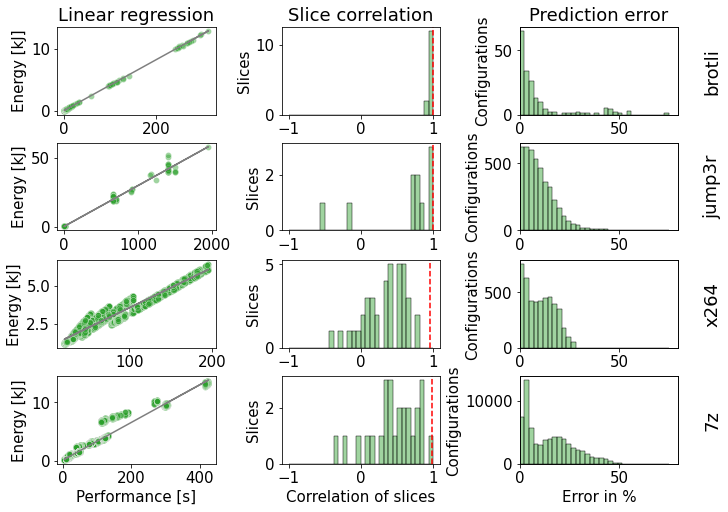

In [19]:
min_window = -1
max_window = 1
min_error = 0
max_error = 0

#palette = [sns.color_palette("husl")[3]]
custom_pal = [sns.color_palette('tab10')[2]]
sns.set_palette(custom_pal)

for df in df_dump_paper_plots:
    if max_error < df['Lin Err Norm'].max():
        max_error = df['Lin Err Norm'].max()
bin_width = 32
bin_width_window = (abs(min_window-max_window))/bin_width
bin_width_error = max_error/bin_width

bins_window = np.arange(min_window, max_window + bin_width_window, bin_width_window)
bins_error = np.arange(min_error, max_error + bin_width_error, bin_width_error)
    
size = 15
plt.rc('font', size=size)
fig, axes = plt.subplots(ncols=3, nrows=4, constrained_layout=True, figsize=(10,7))

curr_row = 0
for i, df in enumerate(df_dump_paper_plots):

    y = df['energy'].to_numpy()
    x = df['performance'].to_numpy()
    
    corr_bb, p_value = scipy.stats.pearsonr(x,y)
    slope, intercept, r, p, stderr = scipy.stats.linregress(x,y)
    
    ax0 = axes[curr_row][0]
    sns.scatterplot(data=df, x='performance', y='energy', ax=ax0, palette=custom_pal, alpha=.45)
    ax0.plot(x, intercept + slope * x, color=sns.color_palette('tab10')[7], label="Regression Line")
    ax0.set_ylabel('Energy [kJ]')
    ax0.set_xlabel('')
    if curr_row == 3: ax0.set_xlabel('Performance [s]')
    if curr_row == 0: ax0.set_title('Linear regression')
    
    
    ax1 = axes[curr_row][1]
    ax1.set_xlim(xmin=-1.1, xmax=1.1)
    correlation_frames = window_sections(df, mode='window')
    sns.histplot(pd.DataFrame(data=correlation_frames, columns=['Pearson']), bins=bins_window, kde=False, ax=ax1, palette=custom_pal, alpha=.45)
    ax1.axvline(corr_bb, ls='--', color='r')
    if curr_row == 3: ax1.set_xlabel('Correlation of slices')
    ax1.set_ylabel('Slices')
    ax1.get_legend().remove()
    if curr_row == 0: 
        ax1.set_title('Slice correlation')
    
    ax2 = axes[curr_row][2]
    ax2.set_xlim(xmin=0, xmax=80)
    sns.histplot(pd.DataFrame(data=df, columns=['Lin Err Norm']), bins=bins_error, kde=False, ax=ax2, palette=custom_pal, alpha=.45)
    if curr_row == 3: ax2.set_xlabel('Error in %')
    ax2.set_ylabel('Configurations')
    if curr_row == 0: ax2.set_title('Prediction error')
    ax2.get_legend().remove()
    
    ax3 = ax2.twinx()
    ax3.axes.yaxis.set_ticks([])
    plt.ylabel('\n' + paper_systems[i], fontsize=18)
    
    curr_row +=1

plt.savefig('./../../RQ1/examplesystems.pdf')
plt.savefig('./../../RQ1/examplesystems.png', dpi=200)

#df_dump_paper_plots

In [ ]:
sns.color_palette('tab10')


In [ ]:
sns.color_palette('Accent')